# **DISCLAIMER**

***THE DATASET USED IN NOTEBOOK IS PURELY SYNTHETIC DATA. THIS IS MEANT FOR TEACHING AND DEMONSTRATION PURPOSES ONLY!***

## **Problem Statement**
Given the great number of clients that use financial services offered by SOS-BETA Bank, it is imperative that a systme is put in place to guide decision making.  
Among the bank's interests, SOS-BETA bank is particulary interested in determining whether or not a client will default a loan when granted as one of the indicators of client eligibility  
for loans.  

With this predicction, SOS-BETA can improve it's operations and prevent deep financial losses.

## **Project Aim**

The general objective of the project to build a model to accuractely predict a bank customer's eligibility for a loan.  

**Specific Objectives**  
1. Predict with high accuracy during training steps  
2. Reveal most important features related to target

<div align="center">
<h1> MODEL TRAINING </h1>
</div>
 

In [1]:
# # mount drive
# from google.colab import drive
# drive.mount('/content/drive')

## Importing Libraries

In [2]:
# DATA MANIPULATION, VISUALIZATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODEL TRAINING - SUPERVISED LEARNING
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

# MODEL SAVING
import joblib
import pickle


import warnings
warnings.filterwarnings('ignore')

## 1. **Data Loading and Inspection**

In [16]:
# loading data
df = pd.read_csv('Bank_Customer_loan_Prediction.csv')

df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,eligible
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.shape

(10000, 12)

**In the target: eligible,**   

**1: ELIGIBLE FOR LOAN**   

**0: NOT ELIGIBLE FOR LOAN**

In [6]:
# summary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  eligible          10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [7]:
# summary stats
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,eligible
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.213300
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.409658
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## **2. EDA & Visualizations**

### **2.1 Distributions**

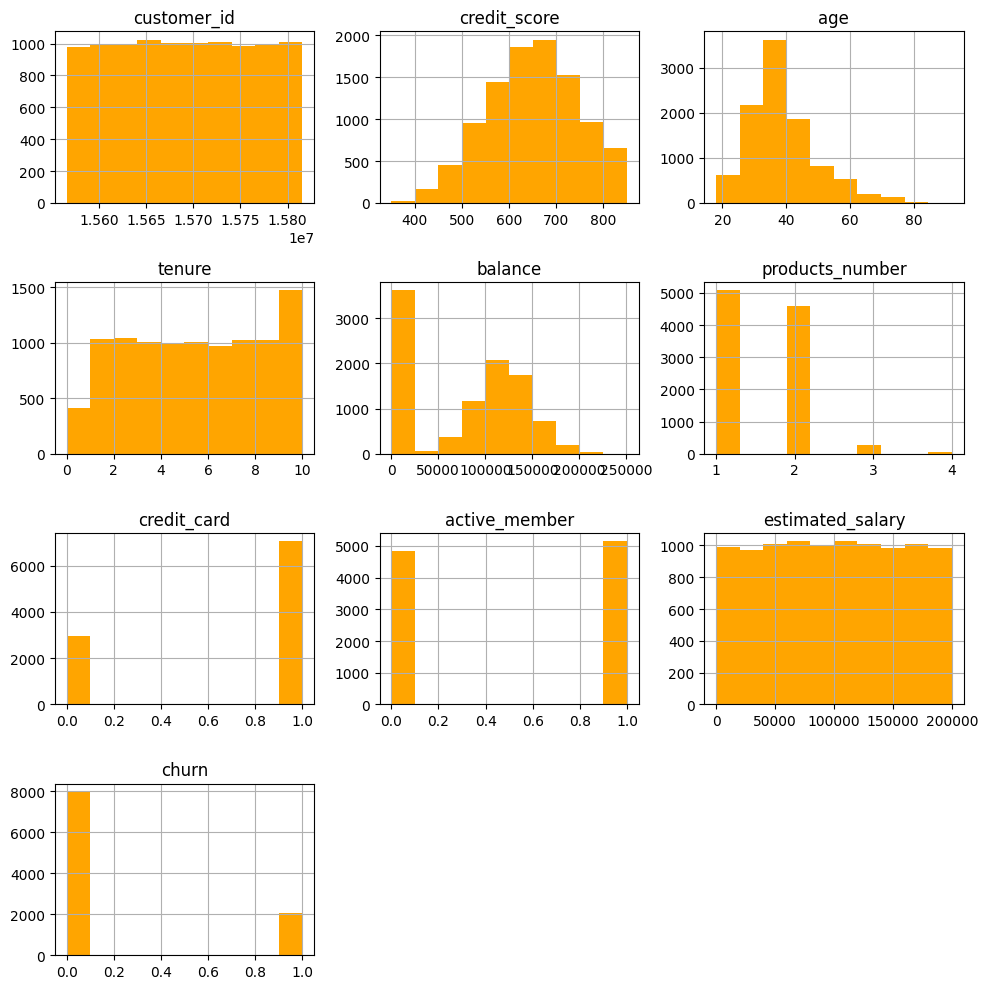

In [10]:
df.hist(figsize=(10,10), color = 'orange')
plt.tight_layout()
plt.show()

### **2.2 Correlations**

In [17]:
numerical_features = df.select_dtypes(include=['float', 'int']).columns.tolist()
# numerical_features

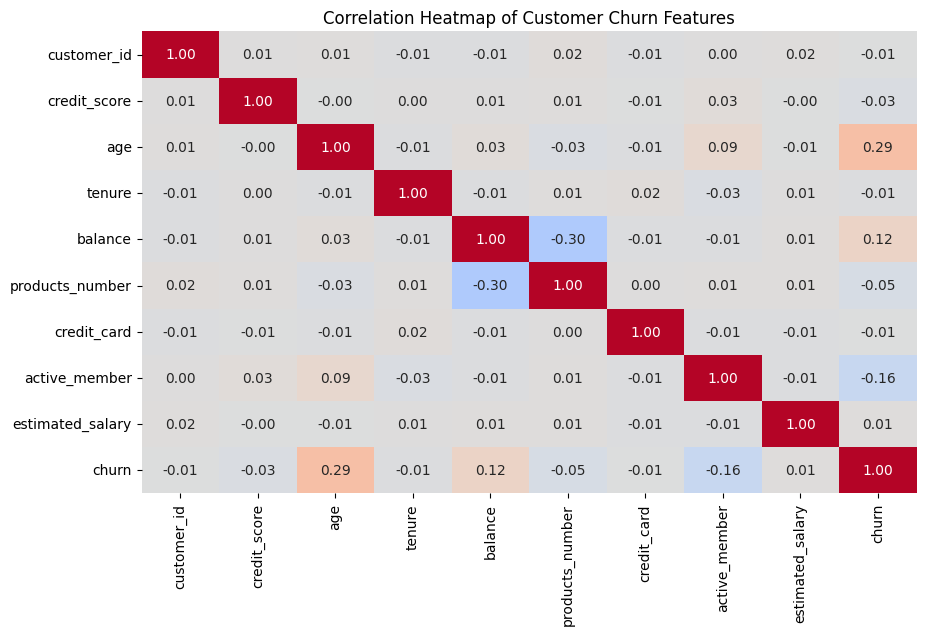

In [12]:
# correlation heatmap
plt.figure(figsize=(10, 6))

corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f',cmap="coolwarm", vmin=-1, vmax=1, cbar=False)
plt.title("Correlation Heatmap of Customer Churn Features")
plt.show()

### **2.3 Eligibility Count**

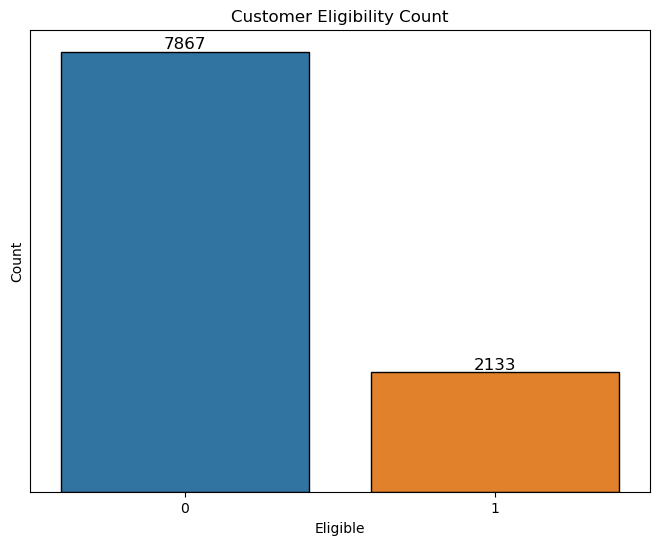

In [18]:
# countplot of churn
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='eligible', edgecolor = 'black')
plt.title('Customer Eligibility Count')
plt.xlabel('Eligible')
plt.yticks([])
plt.ylabel('Count')

# add data labels
ax.bar_label(ax.containers[0], label_type='edge', fontsize = 12)
plt.show()

**There is a clear imbalance of classes, so we'll have to resample using techniques available**

## **3. Data Cleaning**

In [19]:
# check for the number of missing values in each column
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
eligible            0
dtype: int64

In [20]:
# check duplicates
df.duplicated().sum()

0

In [21]:
# drop irrelevent columns and put output into clean_df
df_cleaned = df.drop("customer_id", axis = 1)

In [22]:
df_cleaned.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,eligible
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## **4. Data Preprocessing**

### **4.1 Encoding Categorical features**

In [25]:
# identify columns that need encoding
categorical_features = df_cleaned.select_dtypes(include='object').columns.tolist()

# print(categorical_features)

# apply lable encoder
le = LabelEncoder()
for col in categorical_features:
  df_cleaned[col] = le.fit_transform(df_cleaned[col])

In [26]:
df_cleaned['country'].unique()

array([0, 2, 1])

In [27]:
df_cleaned.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,eligible
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0


### **4.2 Balancing Classes**  

In [28]:
# Separate the classes
class_0 = df_cleaned[df_cleaned['eligible'] == 0.0]
class_1 = df_cleaned[df_cleaned['eligible'] == 1.0]

# Sample 2,000 from each class
sampled_class_0 = class_0.sample(n=2000, random_state=42)
sampled_class_1 = class_1.sample(n=2000, random_state=42)

# Combine the samples
sampled_df = pd.concat([sampled_class_0, sampled_class_1])

# Shuffle the combined dataset
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# count the number of classes sampled
sampled_df['eligible'].value_counts()

eligible
0    2000
1    2000
Name: count, dtype: int64

### **4.3 Data Splitting**

In [29]:
# define features and target
X = df_cleaned.drop(columns = ['eligible'], axis = 1)
y = df_cleaned['eligible']

In [30]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## **5. Building the Model**

### **5.1 Baseline Model: Logistic Regression**

In [31]:
# instantiate and fit the baseline model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# fit the model
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [32]:
# make predictions
predictions = logistic_model.predict(X_test)

In [34]:
# evaluate the model
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

# print results
print(f"Base Model\n{'-'*30}")
print(f"Overall Accuracy: {accuracy}\n{'-'*30}")
print(f"Classification Report:\n{report}\n{'-'*30}")

Base Model
------------------------------
Overall Accuracy: 0.8115
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1590
           1       0.63      0.20      0.30       410

    accuracy                           0.81      2000
   macro avg       0.73      0.58      0.60      2000
weighted avg       0.78      0.81      0.77      2000

------------------------------


### **5.2 Comparison Model(s)**

#### **5.2.1 Gradient Boosting Classifier**

In [35]:
# initialize the gradient boost model
grb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, random_state=42)

# fit the model
grb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, n_estimators=500, random_state=42)

In [36]:
# Predict on the test data
grb_predictions = grb_model.predict(X_test)


# evaluate model
grb_accuracy = accuracy_score(y_test, grb_predictions)
grb_report = classification_report(y_test, grb_predictions)
grb_roc = roc_auc_score(y_test, grb_predictions)


# print out results
print(f"Gradient Boost Model\n{'-'*30}")
print(f"Accuracy: {grb_accuracy}\n{'-'*30}")
print(f"Classification Report:\n{grb_report}\n{'-'*30}")

Gradient Boost Model
------------------------------
Accuracy: 0.843
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1590
           1       0.66      0.49      0.56       410

    accuracy                           0.84      2000
   macro avg       0.77      0.71      0.73      2000
weighted avg       0.83      0.84      0.83      2000

------------------------------


In [37]:
# # optionally check feature importance
# importance_scores = grb_model.feature_importances_

# # visualize importance
# plt.figure(figsize=(10,8))
# plt.bar(range(len(importance_scores)), importance_scores)
# plt.xticks(range(len(importance_scores)), X.columns, rotation = 45)
# plt.title('feature importance')
# plt.show()

#### **5.2.2 XGBoost Classifier**

In [38]:
# instatiate the model
xgb_model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', n_estimators=500, learning_rate = 0.035, random_state=42)

# fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.035, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [39]:
# Predict on the test data
xgb_predictions = xgb_model.predict(X_test)


# evaluate model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_report = classification_report(y_test, xgb_predictions)
xgb_roc = roc_auc_score(y_test, xgb_predictions)


# print out results
print(f"XGBoost Model\n{'-'*30}")
print(f"Accuracy: {xgb_accuracy}\n{'-'*30}")
print(f"Classification Report:\n{xgb_report}\n{'-'*30}")

XGBoost Model
------------------------------
Accuracy: 0.863
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1590
           1       0.75      0.50      0.60       410

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

------------------------------


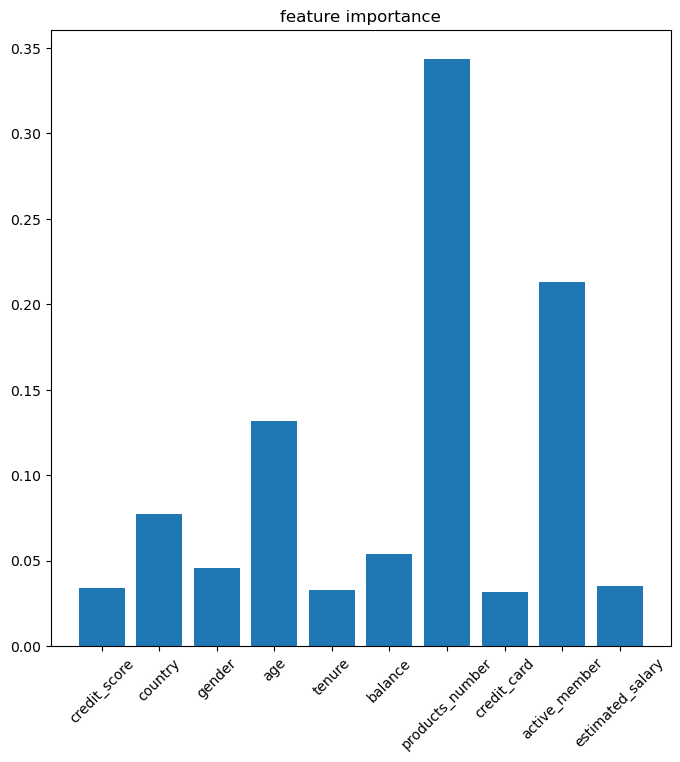

In [41]:
# optionally check feature importance
importance_scores = xgb_model.feature_importances_

# visualize importance
plt.figure(figsize=(8,8))
plt.bar(range(len(importance_scores)), importance_scores)
plt.xticks(range(len(importance_scores)), X.columns, rotation = 45)
plt.title('feature importance')
plt.show()

### **5.3 Save the best model!**

In [42]:
# save the sgboost model
joblib.dump(xgb_model, 'xgb_model.pkl')

# load the model
eligibility_predictor = joblib.load('xgb_model.pkl')

---

## **Conclusion**

After all data wrangling activities, 3 models were trained on the cleaned and preprocessed data.  
Evaluation of these model shows that the XGBoost classifier performs best in predicting the eligibility of a bank customer for a loan.  

With an overall accuracy of $86\%$, the adopted model to be used is the XGBoost Classfier, saved as `xgb_model.pkl`

---